# Ballistics

In [1]:
import os
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from util import store_parameters, Parameters

# Ensure matplotlib is set for inline plotting
#%matplotlib notebook
%matplotlib inline

# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2
#%reload_ext autoreload
import ballistics as b
import plot as p
import util as util

In [2]:
# Constants
m_per_inch = 0.0254

# Inputs
d_min = 0 # m
d_max = 325 # m
step = 25 # m
shooting_angle = 0 # degrees (0 degrees = horizontal). Imagine a shooter on a hill shooting at a target below, distance is measured horizontally to the target from the shooter's position but the actual distance affected by gravity is the horizontal distance to the target. Thus, we adjust the distances in the calculations to account for the shooting angle.
target_size = 0.2 # m

## Scope parameters
mrad_per_click = 0.10
h = 70 / 1000 # m
d_zero = 100 # m

## Bullet parameters
v0 = 921 # m/s
bc = 0.275
bullet_weight = 55 * 0.00006479891  # kg actually mass
bullet_diameter = 0.224 * m_per_inch   # m
bullet_area = pi * (bullet_diameter / 2) ** 2  # m2
bullet_length = 0.75 * m_per_inch
twist_rate = 7 * m_per_inch

## Atmospheric parameters
wind_speed = 6  # wind speed in m/s
wind_angle = 240  # wind direction angle relative to the bullet's path (90 degrees = perpendicular) i.e. relative to shooter
include_spin_and_coriolis_drift = True # Include spin and coriolis drift in the calculations

temp = 6.0 # degrees Celsius
pressure = 1020 * 100 # Pa
humidity = 0.77 # 70% humidity
latitude = 57 # degrees

air_density = b.calculate_air_density(temp, pressure, humidity)
util.set_air_density(air_density)

In [3]:
# Base calculations
bc_metric = b.convert_bc_to_metric(bc)
drag_coefficient_g1 = b.calculate_drag_coefficient(bc_metric, bullet_weight, bullet_area)
barrel_angle = b.calibrate_zero(v0, d_zero, drag_coefficient_g1, bullet_weight, bullet_area, h)

params = Parameters(
    air_density=air_density,
    barrel_angle=barrel_angle,
    initial_velocity=v0,
    drag_coefficient=drag_coefficient_g1,
    height=h,
    zero_distance=d_zero,
    bullet_mass=bullet_weight,
    bullet_cross_sectional_area=bullet_area,
    temperature=temp,
    pressure=pressure,
    humidity=humidity
)

util.store_parameters(params)


Calibrating zero...
Calibration complete. Barrel angle: 0.0005932026561052958
Wrote parameters to parameters.json


In [4]:
# Ballistic vertical components

distances = np.arange(d_min, d_max + step, step)
tbr_distances = b.calculate_true_ballistic_ranges(distances, shooting_angle) # adjusted for shooting angle
d_min = b.calculate_true_ballistic_range(d_min, shooting_angle)
d_max = b.calculate_true_ballistic_range(d_max, shooting_angle)

velocities = b.calculate_velocities(v0, drag_coefficient_g1, bullet_weight, bullet_area, tbr_distances, barrel_angle)
pois = b.calculate_pois(v0, drag_coefficient_g1, bullet_weight, bullet_area, h, barrel_angle, tbr_distances)
pois_mrad = b.calculate_mrads(tbr_distances, pois)
time_to_distances = b.calculate_time_of_flights(v0, drag_coefficient_g1, bullet_weight, bullet_area, tbr_distances, barrel_angle)

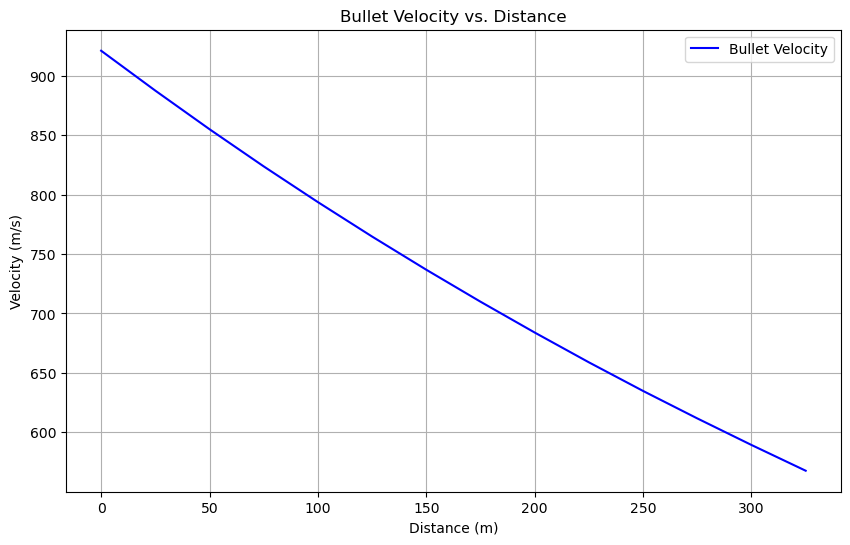

In [5]:
# Plotting the bullet velocity over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, velocities, label='Bullet Velocity', color='blue')
plt.title("Bullet Velocity vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.legend()
plt.show()
plt.close()


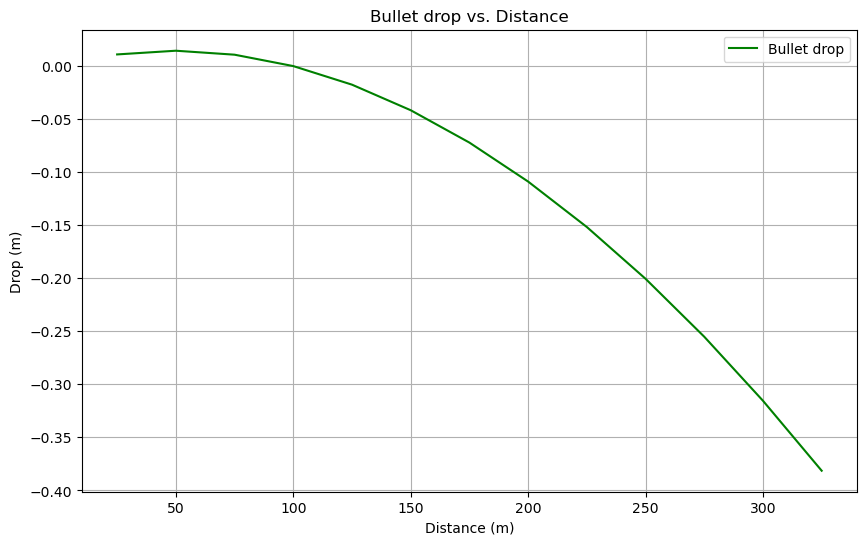

In [6]:
# Plotting the bullet drop over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, pois, label='Bullet drop', color='green')
plt.title("Bullet drop vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Drop (m)")
plt.grid(True)
plt.legend()
plt.show()
plt.close()


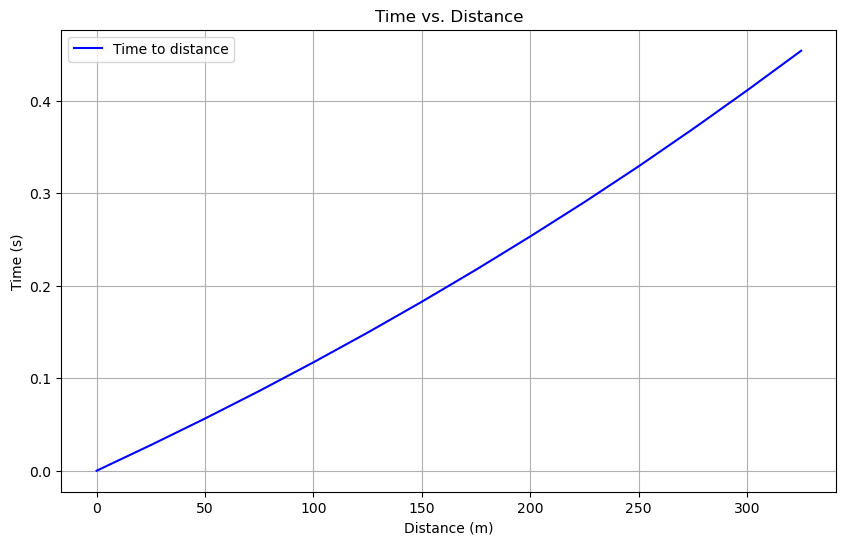

In [7]:
# Plotting the time to distance
plt.figure(figsize=(10, 6))
plt.plot(distances, time_to_distances, label='Time to distance', color='blue')
plt.title("Time vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.show()
plt.close()


In [8]:
# Windage calculation coriolis and spin drift
total_drift, coriolis_drifts = b.calculate_coriolis_drifts(v0, drag_coefficient_g1, bullet_weight, bullet_area, tbr_distances, latitude)

flight_time = b.calculate_time_of_flight(
    v0,
    drag_coefficient_g1,
    bullet_weight,
    bullet_area,
    d_max,
    barrel_angle)
spin_drift = b.calculate_spin_drift(v0, drag_coefficient_g1, d_max, bullet_weight, bullet_area, twist_rate, barrel_angle)
spin_drifts = b.calculate_spin_drifts(v0, tbr_distances, drag_coefficient_g1, bullet_weight, bullet_area, twist_rate, barrel_angle)

total_drift += spin_drift

Total windage drift after 325.0 meters is 0.038 m


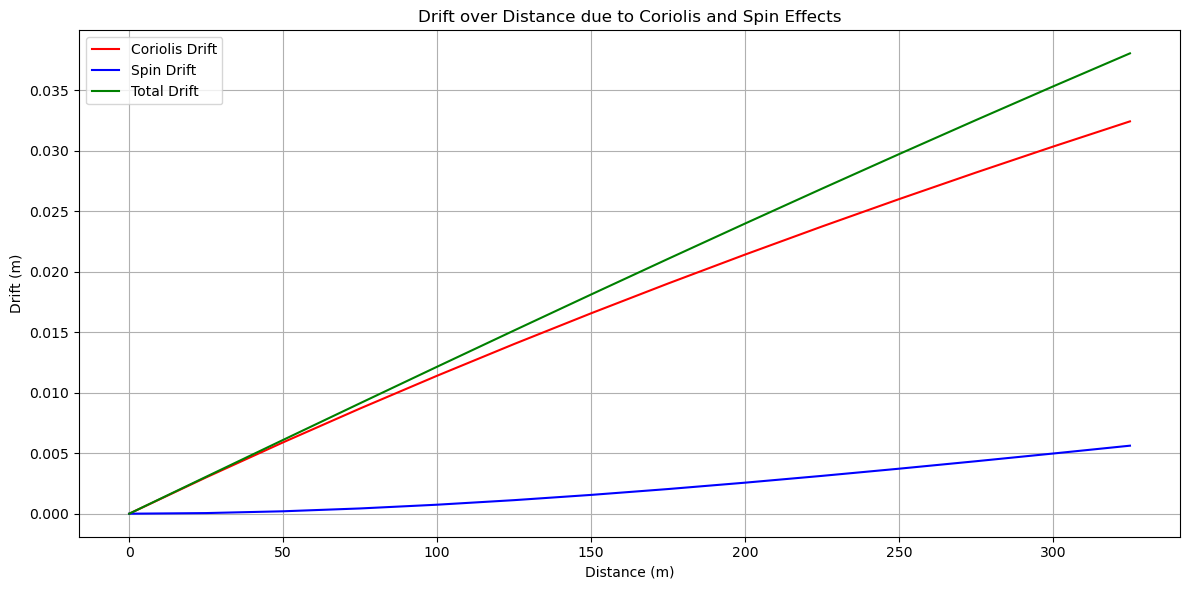

In [9]:
# Windage Plots
print(f"Total windage drift after {d_max} meters is {total_drift:.3f} m")

# Combined plot for Coriolis drift and Spin drift
plt.figure(figsize=(12, 6))

plt.plot(distances, coriolis_drifts, label='Coriolis Drift', color='r')
plt.plot(distances, spin_drifts, label='Spin Drift', color='b')
plt.plot(distances, np.array(spin_drifts) + np.array(coriolis_drifts), label='Total Drift', color='g')
plt.xlabel('Distance (m)')
plt.ylabel('Drift (m)')
plt.title('Drift over Distance due to Coriolis and Spin Effects')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
plt.close()


In [10]:
# Wind drift calculations

wind_drifts = b.calculate_wind_drifts(v0, drag_coefficient_g1, bullet_weight, bullet_area, tbr_distances, wind_speed, wind_angle, barrel_angle)
wind_drifts_cm = np.round(np.array(wind_drifts) * 100, 2)
wind_drifts = np.array(wind_drifts)

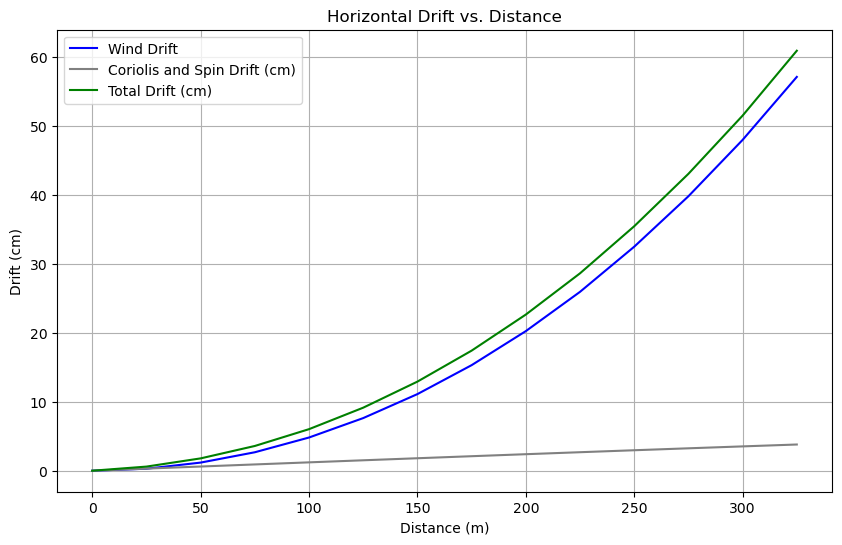

In [11]:
# Windage plot
plt.figure(figsize=(10, 6))
plt.plot(distances, wind_drifts_cm, label='Wind Drift', color='blue')
plt.plot(distances, (spin_drifts+coriolis_drifts)*100, label='Coriolis and Spin Drift (cm)', color='gray')
plt.plot(distances, (wind_drifts+spin_drifts+coriolis_drifts)*100, label='Total Drift (cm)', color='green')
plt.xlabel('Distance (m)')
plt.ylabel('Drift (cm)')
plt.title('Horizontal Drift vs. Distance')
plt.legend()
plt.grid(True)
plt.show()
plt.close()


In [12]:
# Ballistic tables
velocities = np.round(velocities, 0).astype(int)
times = np.round(time_to_distances, 2)
pois = np.round(pois, 2)
pois_mrad = np.round(pois_mrad, 2)
clicks = np.round(np.array(list(map(lambda x: x/mrad_per_click, pois_mrad)))).astype(int)

drift_mrads = b.calculate_mrads(tbr_distances, wind_drifts)
wind_drifts = np.round(wind_drifts, 2)
drift_mrads = np.round(drift_mrads, 2)
windage_clicks = np.round(np.array(list(map(lambda x: x/mrad_per_click, wind_drifts)))).astype(int)

d = {'v (m/s)': velocities, 'time (s)': times, 'drop (m)': pois, 'mrads': pois_mrad, 'clicks (h)': clicks, 'wind drift (cm)': wind_drifts_cm, 'mrad': drift_mrads, 'clicks (w)': windage_clicks}
df = pd.DataFrame(data=d, index=distances)
df

,v (m/s),time (s),drop (m),mrads,clicks (h),wind drift (cm),mrad,clicks (w)
0,921,0.00,NaN,0.00,0,0.00,0.00,0
25,887,0.03,0.01,-0.44,-4,0.29,-0.12,0
50,855,0.06,0.01,-0.29,-3,1.18,-0.24,0
75,824,0.09,0.01,-0.14,-1,2.68,-0.36,0
100,794,0.12,0.00,-0.00,0,4.82,-0.48,0
125,765,0.15,-0.02,0.14,1,7.64,-0.61,1
150,737,0.18,-0.04,0.28,3,11.12,-0.74,1
175,710,0.22,-0.07,0.41,4,15.32,-0.88,1
200,684,0.25,-0.11,0.54,5,20.26,-1.01,2
225,659,0.29,-0.15,0.67,7,25.96,-1.15,3


In [13]:
# Maximum point blank range calculation
mpbr = b.calculate_mpbr(v0, drag_coefficient_g1, bullet_weight, bullet_area, target_size, h, d_zero, barrel_angle)
print(f"Maximum point blank range is: {mpbr:.0f}m")

Maximum point blank range is: 121m


In [14]:
# Create PDF
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')

# Adjust layout
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the table as a PDF file
plt.savefig("ballistic_table.pdf", format="pdf")
plt.close()

print("PDF file created successfully.")

PDF file created successfully.


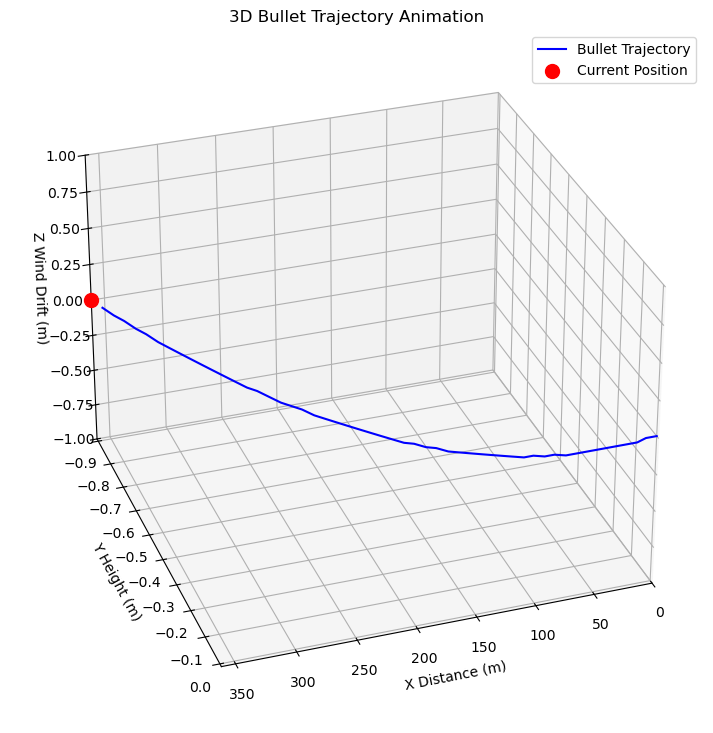

In [15]:
# 3D plot of bullet trajectory
x_vals, y_vals, z_vals, time_interval = b.calculate_projectile_3d_trajectory(v0, drag_coefficient_g1, d_max, bullet_weight, bullet_area, barrel_angle)
x_vals = np.round(x_vals, 2)
y_vals = np.round(y_vals, 2)
z_vals = np.round(z_vals, 2)

anim, plt, fig = p.animate_bullet_trajectory(x_vals, y_vals, z_vals, time_interval)
anim.save("bullet_trajectory_3d.gif", writer='ffmpeg', fps=30)

plt.show()

plt.close()
plt.close(fig)
